In [1]:
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
from itertools import permutations,combinations,combinations_with_replacement

c:\Users\brown\miniconda3\envs\mainenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_ER(r,n):# creates an Erdos-Renyi graph
    adj = np.random.random((n,n))
    adj = (adj<r).astype(int)
    tri = np.tri(n,k=-1)
    adj = tri * adj
    adj = adj + adj.T
    return adj


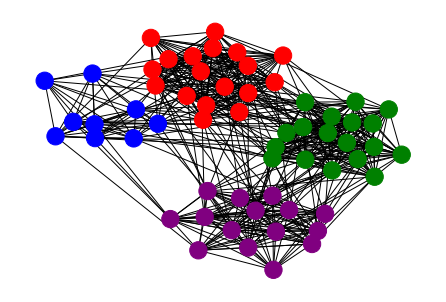

In [4]:
def generate_SBM(n,connection_matrix,edge_possibility,class_possibility):
    """This creates a random graph based on:
        n : how many node we have
        connection_matrix : the likelihood of a node in cluster i connecting to a node in cluster j
        edge_possibility : the likelihood of an edge existing between two nodes
        class_possibility : the likelihood of belonging to any given class"""
    num_clusters = len(class_possibility)
    cluster_assignments = np.sort(np.random.choice(np.arange(num_clusters),p=class_possibility,size=n))
    cluster_indices = [cluster_assignments == a for a in range(num_clusters)]
    cluster_assignments = np.expand_dims(cluster_assignments,1)
    #clusters = cluster_assignments == cluster_assignments.T
    probabilities = np.random.random((n,n))
    adj = np.zeros((n,n))
    for i in range(num_clusters):

        for j in range(num_clusters):
            mask = np.zeros((n,n),dtype=bool)
            imask = np.zeros((n,n))
            imask[cluster_indices[i]] = ~mask[cluster_indices[i]]
            if(len(cluster_indices[i]) !=0 and len(cluster_indices[j]) != 0):
                jmask = np.zeros((n,n))
                jmask[:,cluster_indices[j]] =  ~mask[:,cluster_indices[j]]
                total_mask = jmask*imask
                probs = probabilities

                probs = probs < (connection_matrix[i,j]*edge_possibility)
                #print(probs)
                probs = (total_mask*1)*probs
                #print(probs)
                adj += probs
    tri = np.tri((n),k=-1)
    adj = adj* tri
    adj += adj.T
    #print(cluster_assignments)
    return adj,cluster_assignments
    

    
adj,cluster_assignments = generate_SBM(60,np.array([[1,.1,.1,.1],[.1,1,.1,.1],[.1,.1,1,.1],[.1,.1,.1,1]]),1,[.25,.25,.25,.25])
g = nx.from_numpy_matrix(adj)
pos = []
color_map = []
for i in range(60):
    if(cluster_assignments[i] == 0):
        pos.append(((0+np.random.random(1)-.5)/2,(0+np.random.random(1)-.5)/2))
        color_map.append("blue")
    elif(cluster_assignments[i] == 1):
        pos.append((.5,.25))
        color_map.append("red")
    elif(cluster_assignments[i] == 2):
        pos.append((.25,.5))
        color_map.append("green")
    else:
        color_map.append("purple")
nx.draw_spring(g,node_color=color_map)
plt.show()



379


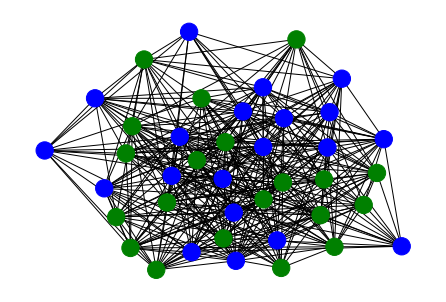

In [6]:
def generate_SSBM(n,c,p_intra,p_inter):
    """This is similar to the above SBM but in this case it is symmetric"""
    # assign a community to each node
    community = np.repeat(list(range(c)),np.ceil(n/c))
    
    #np.repeat(list to iterate over, how many times to repeat an item)

    #make sure community has size n
    community = community[0:n]
    communities = community.copy()
    # just in case repeat repeated too many

    # make it a collumn vector
    community = np.expand_dims(community,1)

    # generate a boolean matrix indicating whether 
    # two nodes share a community
    # this is a smart way to generate a section graph
    intra = community == community.T
    inter = community != community.T# we can also use np.logical not

    random = np.random.random((n,n))
    tri = np.tri(n,k=-1).astype(bool)

    intergraph = (random < p_intra) * intra * tri# this creates a matrix that only has trues where
                                                # random< p_intra, they are in intra, and along half the matrix
                                                # (if it were the whole matrix it would be double the edges we want)
    intragraph = (random < p_inter) * inter * tri# same thing here
    graph = np.logical_or(intergraph,intragraph)
    graph = graph*1# this converts it to a int tensor
    print(np.sum(graph))
    graph += graph.T
    return graph,communities
adj,communities = generate_SSBM(40,2,.5,.5)
g = nx.from_numpy_matrix(adj)
colors = np.ones((40),dtype=str)
colors[np.where(communities == 0)] = "green"
colors[np.where(communities == 1)] = "blue"
colors[np.where(communities == 2)] = "red"
colors[np.where(communities == 3)] = "m"
colors[np.where(communities == 4)] = "yellow"
nx.draw_spring(g,node_color = colors)
    

C:\Users\brown\AppData\Local\Temp\ipykernel_18516\4220648153.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pairs = np.array(pairs).astype(int)


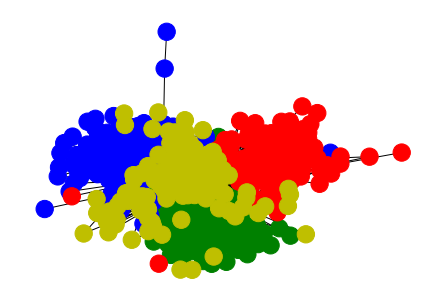

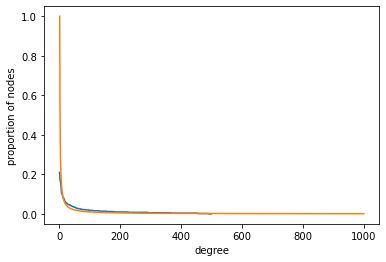

In [7]:
from scipy.stats import poisson
from math import comb
def DC_SBM_adj_edges(num_nodes,num_groups,communities,expected_degrees,group_edge_avg):
    """
    Generates an adjacency matrix by assingning endpoints to edges between two groups

    We loop through every group on group interaction and draw a number according to a 
    poisson distribution that is the number of edges. We then, according to degree, assign 
    endpoints to each edge in between both respective groups. Following this there is some
    post processing to ensure that there are no self loops or repeated edges

    Parameters
    ----------
    num_nodes : int
        The number of nodes in our graph
    num_groups : int
        The number of groups in our graph
    communities : list of size (num_nodes)
        The group assignments of nodes
    expected_degrees : list of size (num_nodes)
        The expected degree for any given node
    group_edge_avg : array of shape (num_groups,num_groups)
        The expected number of edges between any two groups
    """
    N = num_nodes
    w = group_edge_avg
    theta = np.array(expected_degrees)
    adj = np.zeros((N,N))
    
    # These next two are used for debugging purposes
    #   They helped track if the generation process was generating
    #   correct degrees and number of edges
    # total_edges = 0
    # actual_degrees = np.zeros_like(expected_degrees)

    for i in range(num_groups):
        for j in range(i+1):
            # In this we calculuate the expected number of edges between any two groups
            #   using a poisson distribution
            if i != j:# Sometimes we wish to assign less edges within groups, but here we won't
                num_edges = poisson.rvs(group_edge_avg[i,j])
            else:
                num_edges = poisson.rvs(group_edge_avg[i,j])
           
            # total_edges += num_edges # This is for debugging purposes

            # Obtains the indices of the nodes in each community
            group1_indices = np.where(communities == i)[0]
            group2_indices = np.where(communities == j)[0]

            # Obtains a probability(dependent on degree) that a node is the endpoints
            #   of any particular edge
            start_probs = theta[group1_indices]/theta[group1_indices].sum()
            end_probs = theta[group2_indices]/theta[group2_indices].sum()

            # Sampling from a probability distribution we obtain the endpoints for the edges
            start_actuals = np.random.choice(group1_indices,size=(num_edges),p=start_probs)
            end_actuals = np.random.choice(group2_indices,size=num_edges,p=end_probs)

            # This ensures that no edges repeat themselves, and that there are no self loops
            pairs = []
            for k in range(len(start_actuals)):            
                new_pair = [start_actuals[k],end_actuals[k]]
                while new_pair in pairs or new_pair[0] == new_pair[1] or new_pair.reverse() in pairs:
                    new_pair = [np.random.choice(group1_indices,size=(1),p=start_probs),
                    np.random.choice(group2_indices,size=1,p=end_probs)]
                pairs.append(new_pair)

            # Convert to numpy array
            pairs = np.array(pairs).astype(int)

            # This assigns values to the adjacency matrix
            if num_edges > 0:
                adj[pairs[:,0],pairs[:,1]] = 1
                adj[pairs[:,1],pairs[:,0]] = 1

                # next two are used for debugging
                # actual_degrees[pairs[:,0]] += 1
                # actual_degrees[pairs[:,1]] += 1
    return adj

def get_features(num_nodes,num_features,num_classes,mu,communities):
    """
    Generates random cluster clouds for our groups
    """
    u = np.random.normal(0,1/num_features,(num_features)) # obtains the random normal vector u
    Z = np.random.normal(0,.2,(num_nodes,num_features)) # obtains the random noise vector i presume
    v = communities # puts the groups into a format for the equations
    
    perms = generate_perms_rand(num_classes,num_features)
    b = np.zeros((num_nodes,num_features))
    for i in range(num_nodes):
        b[i] = np.sqrt(mu/num_nodes)*(np.diag(perms[v[i]])@u) + Z[i]/np.sqrt(num_features)
    return b

def generate_perms_rand(num_classes,num_feat):
    """
    Generates orthogonal directions for the cluster clouds
    """
    vecs = []
    for i in range(num_classes):
        orthogonal = False
        while(not orthogonal):
            rand_vec = np.random.uniform(-10,10,num_feat)
            rand_vec = rand_vec/np.linalg.norm(rand_vec)
            orthogonal = True
            for j in range(len(vecs)):
                angle = np.arccos(rand_vec@vecs[j])
                if(angle < np.pi/2 - .1 or angle > np.pi/2 + .1):
                    orthogonal = False
        vecs.append(rand_vec)
    return np.array(vecs)

def DC_SSBM(num_nodes,num_groups,num_features,lamb,mu,density_enhancer = 1.5):
    """
    Generates a Degree Corrected Stochastic Block Model with Features
    
    We first assign communities to each node, then we assign them degrees(generated randomly) from
    a powerlaw distribution. Following this we obtain w(a parameter used to calculate edges in the SBM)
    using the degrees. Then we obtain the adjacency matrix and the features usign other methods.

    Parameters
    ----------
    num_nodes : int
        The number of nodes
    num_groups : int
        The number of groups
    num_features : int
        The number of features
    lamb : float ϵ [0,1]
        How informative we want our edges to be.
        0 = completely random, 1 = completely segregated groups
    mu : float ϵ [0,6]
        How far our degree clouds are from the origin
    density_enhancer : float ϵ [1,5]
        Increases the density of our graph, helps to reduce number
        of isolated nodes.
    """
    # assign communities to all of our nodes
    community = np.repeat(list(range(num_groups)),np.ceil(num_nodes/num_groups))
    communities = community[:num_nodes]

    # get expected degrees for each node according to a powerlaw distribution
    p = np.arange((num_nodes)-1) + 1
    p = 1/(p*p)
    p = p/p.sum() 
    degrees = np.random.choice(np.arange(num_nodes-1) + 1, size = (num_nodes), p = p)

    # we sort degrees according to their groups then obtain total degrees for each group
    theta = degrees.copy()
    theta = theta.reshape(num_groups,num_nodes//num_groups)
    group_deg = theta.sum(axis=1)
    theta = np.sort(theta) # this automatically sorts along the final axis, or sort within each group
    theta = theta.flatten()
    
    num_edges = sum(group_deg)/2

    group_deg = np.array(group_deg)

    # obtain w as a mix between planted and random graphs
    w_planted = np.diag(group_deg)*density_enhancer
    w_random = np.outer(group_deg,group_deg)/(2*num_edges)*density_enhancer# not sure if this is normalized as we want it
    w = lamb*w_planted + (1-lamb)*w_random

    # obtain our adjacency matrix along with the corrosponding features
    adj = DC_SBM_adj_edges(num_nodes,num_groups,communities,theta, w)
    features = get_features(num_nodes,num_features,num_groups,mu,communities)

    #README the feature generation does not take class size into account, or community ordering. If you wanted
    # to specify this you could.
    return adj,features,communities

def draw_graph(adj,communities):
    """
    Draws the graph

    This assigns colors according to the communities. Warning -
    does not work well for graphs of over 500 nodes. Additionally
    parameters only color nodes up to 4 different groups, additional
    coloring can be added. Isolated nodes are removed to enhance 
    visibility.

    Parameters
    ----------
    adj : numpy array of shape (num_nodes, num_nodes)
        The adjacency matrix
    communities : list of size (num_nodes)
        The community assignments
    """
    g = nx.from_numpy_array(adj)
    isos = list(nx.isolates(g))
    mask = np.ones(len(communities), dtype=bool)
    mask[isos] = False
    #print(nx.number_of_isolates(g)) # used for debugging
    communities = communities[mask]
    g.remove_nodes_from(isos)
    g.remove_edges_from(nx.selfloop_edges(g))
    colors = np.zeros((nx.number_of_nodes(g)),dtype=str)
    colors[np.where(communities == 0)] = "green"
    colors[np.where(communities == 1)] = "blue"
    colors[np.where(communities == 2)] = "red"
    colors[np.where(communities == 3)] = "yellow"
    nx.draw(g,node_color=colors)
    plt.show()

def degree_distribution(adj):
    """
    Figures out the degree distribution of our generated graph

    The degree distribution(blue) of our graph is plotted against
    the graph 1/x^2(orange)
    """
    g = nx.from_numpy_array(adj)
    degree_sequence = np.array(sorted((d for n, d in g.degree()), reverse=True))/nx.number_of_nodes(g)
    plt.plot(degree_sequence)
    x = np.linspace(1,1000,10000)
    y = 1/(x)
    plt.plot(x,y)
    plt.xlabel("degree")
    plt.ylabel("proportion of nodes")
    plt.show()

adj,b,communities = DC_SSBM(500,4,10,.7,3)

draw_graph(adj,communities)
degree_distribution(adj)


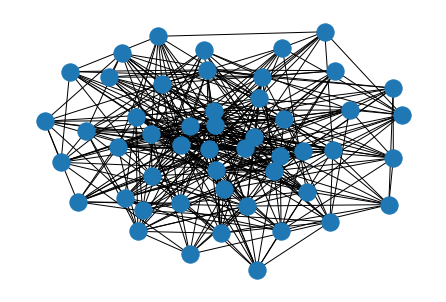

In [8]:
def generate_PA(n,m):# creates a Preferential attachment graph
    G = nx.barabasi_albert_graph(n,m=m)
    return nx.to_numpy_array(G)
adj = generate_PA(50,10)
g = nx.from_numpy_array(adj)
#a = plt.hist(adj.sum(axis=0),bins=np.arange(0,40,1))
adj.sum(axis=0)
nx.draw_spring(g)

The following code implements the algorithm outlined in the cSBM paper

\begin{equation}
  \mathbb{P}(A_{ij}^{G} = 1)=
  \begin{cases}
    c_{in}/n, & \text{if both i and j are in the same cluster}\ \\
    c_{out}/n, & \text{otherwise}\
  \end{cases}
\end{equation}
\begin{equation}
b_{i}=\sqrt{\frac{\mu}{n}}v_{i}u+\frac{Z_i}{\sqrt{p}}
\end{equation}
\begin{equation}
c_{in} = d+\lambda \sqrt{d}, c_{out}=d-\lambda \sqrt{d}
\end{equation}
u is a normal random vector drawn before everything else is computed, $u\in \mathbb{R}^{p}$<br>
Z is a normal random matrix, likewise drawn before anything else is computed, $Z \in \mathbb{R}^{n\times p}$<br>
v is also a vector that encodes the partitioning of the clusters, $v \in {\{0,1\}}^{n}$<br>
Something key to observe is a specific quantity $\phi$
\begin{equation}
\xi = n/p
\end{equation}
\begin{equation}
\phi = \arctan{(\frac{\lambda \sqrt{\xi}}{\mu})} \times 2/\pi
\end{equation}
if $\phi = 0$ then the graph structure is entirely uninformative with the features more informative<br>
if $\phi > 0$ then the graph is more homophilic, with $\phi < 0$ indicating it is more heterophilic<br>
if $|\phi| = 1$ then the graph stucture is entirely informative and the features are uninformative

In [9]:
def generate_perms_cube(num_classes,num_feat):
    assert num_classes <= 2**num_feat
    dims = np.ceil(np.log2(num_classes))+1
    vecs = []
    #vec1 = np.ones(num_feat)
    #vecs.append(vec1.copy())
    #vec1[-1] = -1
    #vec1[-2] = -1
    #perms = list(set(permutations(vec1)))


    combs = np.array(list(combinations_with_replacement([0,1],num_feat)))
    total = []
    for i in range(len(combs)):
        total.append(set(permutations(combs[i])))
    for i in total:
        for j in i:
            vecs.append(j)
    
    #print(perms)
    #for i in perms:
    #    vecs.append(i)
    #print(vecs)
    return np.array(vecs[:num_classes])

# this next one is a better way of generating the permutations
def generate_perms_rand(num_classes,num_feat):
    vecs = []
    for i in range(num_classes):
        orthogonal = False
        while(not orthogonal):
            rand_vec = np.random.uniform(-10,10,num_feat)
            rand_vec = rand_vec/np.linalg.norm(rand_vec)
            orthogonal = True
            for i in range(len(vecs)):
                angle = np.arccos(rand_vec@vecs[i])
                if(angle < np.pi/2 - .1 or angle > np.pi/2 + .1):
                    orthogonal = False
        vecs.append(rand_vec)
        #print(len(vecs))
    return np.array(vecs)
                

        
a = generate_perms_rand(8,100)

58


c:\Users\brown\miniconda3\envs\mainenv\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


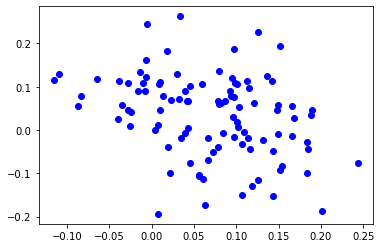

In [10]:
def generate_cSBM(d,lamb,mu,num_features,num_nodes,num_classes):
    c_in = d+lamb*np.sqrt(d) # c_in/c_out as described in the equations
    c_out = d-lamb*np.sqrt(d) 
    p_in = c_in/num_nodes # compiles these to pass into the SSBM
    p_out = c_out/num_nodes
    
    adj, communities = generate_SSBM(num_nodes,num_classes,p_in,p_out) # obtains the graph structure
    u = np.random.normal(0,1/num_features,(num_features)) # obtains the random normal vector u
    Z = np.random.normal(0,.2,(num_nodes,num_features)) # obtains the random noise vector i presume
    v = communities # puts the groups into a format for the equations
    
    perms = generate_perms_rand(num_classes,num_features)
    #print(communities)
    #print(perms)
    b = np.zeros((num_nodes,num_features))
    for i in range(num_nodes):
        b[i] = np.sqrt(mu/num_nodes)*(np.diag(perms[v[i]])@u) + Z[i]/np.sqrt(num_features)
    return adj,b,communities



adj,b,labels = generate_cSBM(1,.5,250,4,100,2)
fig = plt.figure()
#ax = plt.axes(projection = "3d")
#ax.plot3D(b[:,0],b[:,1],b[:,2],"bo")
W = 1/len(b)*(b@b.T)
L,P = np.linalg.eig(W)
idx = np.flip(np.argsort(L))
P = P.T[idx]
# PCA
plt.plot(P[0],P[1],"bo")
#plt.plot(b[:,0],b[:,1],"bo")

# GCN
The following code implements the cSBM for two classes to run a GCN on 

In [11]:
from torch_geometric.nn import GCNConv,GATConv
import torch.nn as nn
import torch.nn.functional as F
class GCN(torch.nn.Module):# this is the torch geometric implementation of our GCN model like before, it
    # is a lot simpler to implement and way customizeable
    def __init__(self, in_feat, hid_feat, out_feat):
        super().__init__()
        self.conv1 = GCNConv(in_feat, hid_feat)
        self.convh = GCNConv(hid_feat,hid_feat)# adding an extra hidden layer essentially solves exact recovery
        # the size of the hidden layers just have to be greater than or equal to the size of the output layer
        self.conv2 = GCNConv(hid_feat, out_feat)
        self.activation = nn.ReLU()
        #self.dropout = nn.Dropout(p=.4)

    def forward(self, x,edge_index):
        x = self.activation(self.conv1(x, edge_index))
        x = F.dropout(x, training= self.training)
        x = self.activation(self.convh(x,edge_index))
        x = F.dropout(x,training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x,dim=1)

def adj_to_list(a):
    adjList =[[],[]]
    for i in range(len(a)):
        for j in range(len(a[i])):
            if a[i][j]== 1:
                adjList[0].append(i)
                adjList[1].append(j)
    return adjList

def accuracy(preds,mask):# obtains the accuracy of the model
    correct = (preds[mask] == labels[mask]).sum()
    acc = int(correct)/int(mask.sum())
    return acc




In [12]:
# these are the hyperparameters to generate the graph/features, still unsure how tweaking them would change the graph
d=10 # this is the average degree
lamb = 30 # difference in edge_densities, 0 indicates only node features are informative lamb>0 means more intra edges vs inter edges(homophily)
# lamb < 0 means less intra edges vs inter edges(heterophily)
mu = 50# difference between the means of the two classes, increasing this means increasing difference between class features
num_nodes = 1000
num_features = 30
num_classes=7


# our hyperparameter for our hidden model
hidden_layers = 10
lr = .01
epochs = 400

In [13]:
#this sets up our variables to use in training
adj, b, labels = generate_cSBM(d,lamb,mu,num_features,num_nodes,num_classes)
edge_list = adj_to_list(adj)

# sets up model/optimizer
model = GCN(num_features,hidden_layers,num_classes)
optimizer = torch.optim.Adam(params=model.parameters(),lr = lr)

# creates some masks so we have stuff for training and validation
train_mask = torch.tensor([False,True]).repeat(num_nodes//2)
val_mask = ~train_mask

# turns all of our tensors into the desired format
edge_list = torch.Tensor(edge_list).to(torch.long)
b = torch.Tensor(b)
labels = torch.Tensor(labels).to(torch.long)


7323


epoch: 0 training_loss: 1.9455327987670898 training_acc: 0.15 val_loss: 1.9455655813217163 val_acc: 0.14
epoch: 5 training_loss: 1.9385006427764893 training_acc: 0.154 val_loss: 1.9394575357437134 val_acc: 0.144
epoch: 10 training_loss: 1.9342436790466309 training_acc: 0.228 val_loss: 1.93589448928833 val_acc: 0.216
epoch: 15 training_loss: 1.9280339479446411 training_acc: 0.296 val_loss: 1.9293596744537354 val_acc: 0.274
epoch: 20 training_loss: 1.9141000509262085 training_acc: 0.338 val_loss: 1.9183886051177979 val_acc: 0.296
epoch: 25 training_loss: 1.8987774848937988 training_acc: 0.438 val_loss: 1.9028654098510742 val_acc: 0.404
epoch: 30 training_loss: 1.8683370351791382 training_acc: 0.362 val_loss: 1.8666969537734985 val_acc: 0.368
epoch: 35 training_loss: 1.8301854133605957 training_acc: 0.476 val_loss: 1.8329023122787476 val_acc: 0.468
epoch: 40 training_loss: 1.78190279006958 training_acc: 0.546 val_loss: 1.7915383577346802 val_acc: 0.536
epoch: 45 training_loss: 1.710209250

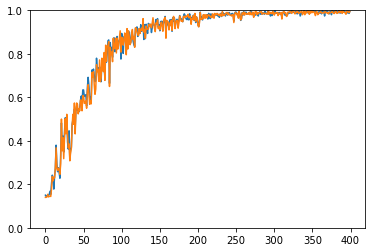

In [14]:
# This cell actually trains the model
model.train()# tells our model we are about to train
losses = []
accs = []
for epoch in range(epochs):# runs through all the data 200 times
    if(epoch %2 == 6):
        adj, b, labels = generate_cSBM(d,lamb,mu,num_features,num_nodes,num_classes)
        edge_list = adj_to_list(adj)
        edge_list = torch.Tensor(edge_list).to(torch.long)
        b = torch.Tensor(b)
        labels = torch.Tensor(labels).to(torch.long)
    
    
    optimizer.zero_grad()
    out = model(b,edge_list)

    train_loss = F.nll_loss(out[train_mask], labels[train_mask])
    train_acc = accuracy(out.max(1)[1], train_mask)

    val_loss = F.nll_loss(out[val_mask], labels[val_mask])
    val_acc = accuracy(out.max(1)[1], val_mask)
    losses.append([train_loss.item(),val_loss.item()])
    accs.append([train_acc,val_acc])
    if(epoch %5 == 0):
        print("epoch: {} training_loss: {} training_acc: {} val_loss: {} val_acc: {}".format(epoch,train_loss,train_acc,val_loss, val_acc))
        
    train_loss.backward()
    optimizer.step()

losses = np.array(losses)
accs = np.array(accs)
plt.plot(accs[:,0])
plt.plot(accs[:,1])
plt.ylim(0,1)

model.eval()
out = model(b,edge_list)
test_acc = accuracy(out.max(1)[1],torch.ones(num_nodes).to(torch.bool))
print(test_acc)